## Library Import

In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from collections import Counter

## Data Load

In [2]:
# 데이터 경로 설정
data_path = "~/movie/data/train"

# 전체 학습 데이터 불러오기
train_ratings = pd.read_csv(os.path.join(data_path, "train_ratings.csv"))

# 아이템 side information 불러오기
years = pd.read_csv(os.path.join(data_path, "years.tsv"), sep="\t")
writers = pd.read_csv(os.path.join(data_path, "writers.tsv"), sep="\t")
titles = pd.read_csv(os.path.join(data_path, "titles.tsv"), sep="\t")
genres = pd.read_csv(os.path.join(data_path, "genres.tsv"), sep="\t")
directors = pd.read_csv(os.path.join(data_path, "directors.tsv"), sep="\t")

In [3]:
# side information을 하나의 아이템 데이터프레임으로 병합
item_df = pd.merge(titles, years, on="item", how="left")
item_df = pd.merge(item_df, genres, on="item", how="left")
item_df = pd.merge(item_df, directors, on="item", how="left")
item_df = pd.merge(item_df, writers, on="item", how="left")

In [4]:
item_df.head(20)

,item,title,year,genre,director,writer
0,318,"Shawshank Redemption, The (1994)",1994.0,Crime,nm0001104,nm0000175
1,318,"Shawshank Redemption, The (1994)",1994.0,Crime,nm0001104,nm0001104
2,318,"Shawshank Redemption, The (1994)",1994.0,Drama,nm0001104,nm0000175
3,318,"Shawshank Redemption, The (1994)",1994.0,Drama,nm0001104,nm0001104
4,2571,"Matrix, The (1999)",1999.0,Action,nm0905152,nm0905152
5,2571,"Matrix, The (1999)",1999.0,Action,nm0905152,nm0905154
6,2571,"Matrix, The (1999)",1999.0,Action,nm0905154,nm0905152
7,2571,"Matrix, The (1999)",1999.0,Action,nm0905154,nm0905154
8,2571,"Matrix, The (1999)",1999.0,Sci-Fi,nm0905152,nm0905152
9,2571,"Matrix, The (1999)",1999.0,Sci-Fi,nm0905152,nm0905154


## Data Preprocessing

### 1. `year`

결측치를 `title`에 포함된 연도 정보를 활용해 대체한다.

In [5]:
# year 결측치 확인
item_df[item_df["year"].isna()]

,item,title,year,genre,director,writer
9583,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",NaN,Crime,NaN,nm0562346
9584,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",NaN,Fantasy,NaN,nm0562346
9585,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",NaN,Horror,NaN,nm0562346
10944,3310,"Kid, The (1921)",NaN,Comedy,nm0000122,nm0000122
10945,3310,"Kid, The (1921)",NaN,Drama,nm0000122,nm0000122
15109,7065,"Birth of a Nation, The (1915)",NaN,Drama,nm0000428,nm0000428
15110,7065,"Birth of a Nation, The (1915)",NaN,Drama,nm0000428,nm0940488
15111,7065,"Birth of a Nation, The (1915)",NaN,War,nm0000428,nm0000428
15112,7065,"Birth of a Nation, The (1915)",NaN,War,nm0000428,nm0940488
16055,7243,Intolerance: Love's Struggle Throughout the Ag...,NaN,Drama,nm0000428,nm0000428


In [6]:
# title에서 괄호 안 연도 추출해 year 결측치 대체
item_df["year"] = item_df["year"].fillna(
    item_df["title"].str.extract(r"\((\d{4})\)", expand=False)  # 괄호 안 네 자리 숫자를 추출하는 정규표현식
).astype("int64")

# 결과 확인
print(item_df[item_df["year"].isna()])  # 여전히 NaN인 경우 확인

Empty DataFrame
Columns: [item, title, year, genre, director, writer]
Index: []


### 2. `title`

#### 2.1 같은 `title`, 다른 `item` 처리
같은 영화 중 다른 item 값을 갖는 데이터 중 결측치가 없는 item을 기준으로 통일시킨다.

In [7]:
delete_title = (titles["title"].value_counts() > 1).index[0]
print("Before droping the indices")
display(item_df[item_df["title"] == delete_title])

# 중복된 title을 갖는 item 제거
item_df = item_df.drop(index=[13507, 13508])
print("\nAfter drop the indices")
display(item_df[item_df["title"] == delete_title])

Before droping the indices


,item,title,year,genre,director,writer
3584,34048,War of the Worlds (2005),2005,Action,nm0000229,nm0295264
3585,34048,War of the Worlds (2005),2005,Action,nm0000229,nm0462895
3586,34048,War of the Worlds (2005),2005,Action,nm0000229,nm0920229
3587,34048,War of the Worlds (2005),2005,Adventure,nm0000229,nm0295264
3588,34048,War of the Worlds (2005),2005,Adventure,nm0000229,nm0462895
3589,34048,War of the Worlds (2005),2005,Adventure,nm0000229,nm0920229
3590,34048,War of the Worlds (2005),2005,Sci-Fi,nm0000229,nm0295264
3591,34048,War of the Worlds (2005),2005,Sci-Fi,nm0000229,nm0462895
3592,34048,War of the Worlds (2005),2005,Sci-Fi,nm0000229,nm0920229
3593,34048,War of the Worlds (2005),2005,Thriller,nm0000229,nm0295264



After drop the indices


,item,title,year,genre,director,writer
3584,34048,War of the Worlds (2005),2005,Action,nm0000229,nm0295264
3585,34048,War of the Worlds (2005),2005,Action,nm0000229,nm0462895
3586,34048,War of the Worlds (2005),2005,Action,nm0000229,nm0920229
3587,34048,War of the Worlds (2005),2005,Adventure,nm0000229,nm0295264
3588,34048,War of the Worlds (2005),2005,Adventure,nm0000229,nm0462895
3589,34048,War of the Worlds (2005),2005,Adventure,nm0000229,nm0920229
3590,34048,War of the Worlds (2005),2005,Sci-Fi,nm0000229,nm0295264
3591,34048,War of the Worlds (2005),2005,Sci-Fi,nm0000229,nm0462895
3592,34048,War of the Worlds (2005),2005,Sci-Fi,nm0000229,nm0920229
3593,34048,War of the Worlds (2005),2005,Thriller,nm0000229,nm0295264


In [8]:
# train_ratings에서 item 값을 변경하고자 하는 인덱스 목록 추출
idx = train_ratings[(train_ratings["item"] == 64997)].index

# 원하는 item 값으로 변경
train_ratings.loc[idx, "item"] = 34048

In [9]:
# 결측치 대체가 잘 됐는지 확인
train_ratings[(train_ratings["item"] == 64997)]

,user,item,time


#### 2.2 `title` 재구성

현재 `title`은 _**"영문 제목 (a.k.a. 별칭) (원어 제목) (연도)"**_ 순으로 구성되어 있다. 정규표현식을 활용하여 다음 순서대로 `title`을 재구성한다.

1. 따옴표(”, ‘) 제거
2. 영문 제목만 선택
3. 관사 위치 재조정: "~, The"를 "The ~"로 변경
4. 특수문자 삭제
5. 소문자로 통일

In [3]:
def preprocess_title(title):
    # 1. 따옴표(”, ‘) 제거
    title = re.sub(r'^[\'"](.*)[\'"]$', r'\1', title)
    
    # 2. 영문 제목만 추출
    title = re.match(r'^[^(]+', title).group().strip() if re.match(r'^[^(]+', title) else title
    
    # 3. "~, The", "~, A", "~, An" 형태를 "The ~", "A ~", "An ~"으로 변경
    title = re.sub(r'^(.*),\s(The|A|An)$', r'\2 \1', title)
    
    # 4. 특수문자 제거
    title = re.sub(r'[^a-zA-Z0-9\s]', '', title)
    
    # 5. 소문자로 변환
    title = title.lower()
    
    return title

In [11]:
item_df["title"] = item_df["title"].apply(preprocess_title)

### 3. `director`

In [12]:
item_director_counts = directors.groupby('item')['director'].nunique().reset_index()
item_director_counts.columns = ['item', 'director_count']

director_counts = item_director_counts.groupby('director_count').count().reset_index()
director_counts.columns = ['director_count', 'count']
director_counts["count"].sum()

5503

### 4. `writer`

### 5. `genre`

In [4]:
# 함수 정의: 피벗별로 상위 k개의 레벨만 남기기
def filter_top_k_by_count(df, sel_col, pivot_col, top_k, ascending=False):
    # 1. 레벨별 전체 등장 빈도 계산
    col_count = df[sel_col].value_counts().reset_index()
    col_count.columns = [sel_col, "count"]
    
    # 2. 원본 데이터프레임에 레벨 count 추가
    df = df.merge(col_count, on=sel_col)
    
    # 3. 각 피벗별로 상위 N개의 레벨 남기기
    filtered_df = df.groupby(pivot_col).apply(
        (lambda x: x.nsmallest(top_k, "count")) if ascending else (lambda x: x.nlargest(top_k, "count"))
    ).reset_index(drop=True)
    
    # 4. count 열 제거 후 결과 반환
    filtered_df = filtered_df.drop(columns=["count"])
    
    return filtered_df

In [14]:
# 함수 실행
genres = filter_top_k_by_count(genres, sel_col="genre", pivot_col="item", top_k=4)
genres

/tmp/ipykernel_665512/1471133371.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby(pivot_col).apply(


,item,genre
0,1,Comedy
1,1,Adventure
2,1,Fantasy
3,1,Children
4,2,Adventure
...,...,...
15609,119141,Action
15610,119145,Comedy
15611,119145,Action
15612,119145,Crime


In [5]:
# 함수 정의: 멀티-핫-인코딩 하기
def multi_hot_encoding(df: pd.DataFrame,
                       label_col: str,
                       pivot_col: str
                       ) -> pd.DataFrame:
    """
    범주형 데이터에서 여러 개의 선택 가능한 값을 이진 벡터(binary vector)로 변환합니다.

    Args:
        df (pd.DataFrame): pivot_col과 label_col을 column으로 갖는 데이터프레임
        label_col (str): 데이터프레임에서 멀티 핫 인코딩을 적용할 범주형 변수명
        pivot_col (str): 데이터프레임에서 그룹화할 기준이 되는 변수명

    Returns:
        pd.DataFrame: 멀티-핫-인코딩이 완료된 데이터프레임 반환.
    """

    # 1. pivot_col별 label_col을 리스트로 묶기
    grouped_df = df.groupby(pivot_col)[label_col].apply(lambda x: list(x)).reset_index()

    # 2. MultiLabelBinarizer를 사용하여 멀티 핫 인코딩 수행
    mlb = MultiLabelBinarizer()
    multi_hot_encoded = mlb.fit_transform(grouped_df[label_col])

    # 3. 결과를 데이터프레임으로 변환
    multi_hot_df = pd.DataFrame(multi_hot_encoded, columns=mlb.classes_)

    # 4. 원본 데이터프레임과 결합
    result_df = pd.concat([grouped_df[pivot_col], multi_hot_df], axis=1)

    return result_df

In [16]:
genres_mhe = multi_hot_encoding(genres, label_col="genre", pivot_col="item")
genres_mhe

,item,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,118700,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6803,118900,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6804,118997,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
6805,119141,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# 그룹화 및 병합
grouped_df = item_df.groupby(['item', 'title', 'year']).agg({
    'genre': lambda x: list(x.unique()),
    'director': lambda x: list(x.unique()),
    'writer': lambda x: list(x.unique())
}).reset_index()

## Feature Engineering

In [18]:
# train_ratings와 item_df를 최종 병합
train_df = pd.merge(train_ratings, item_df, on="item", how="left")

### 파생변수 생성

In [6]:
# 함수 정의: num_negative만큼 negative_sampling하기
def negative_sampling(df:pd.DataFrame,
                      user_col: str,
                      item_col: str,
                      num_negative: float
                      ) -> pd.DataFrame:
    """
    _summary_

    Args:
        df (pd.DataFrame): user_col과 item_col을 column으로 갖는 데이터프레임
        user_col (str): _description_
        item_col (str): _description_
        num_negative (float): _description_

    Returns:
        pd.DataFrame: negative_sampling
    """

    df['review'] = 1
    user_group_dfs = list(df.groupby(user_col)[item_col])
    first_row = True
    user_neg_dfs = pd.DataFrame()
    items = set(df.loc[:, item_col])

    for u, u_items in tqdm(user_group_dfs):
        u_items = set(u_items)
        i_user_neg_item = np.random.choice(list(items - u_items), num_negative, replace=False)
        i_user_neg_df = pd.DataFrame({user_col: [u]*num_negative, item_col: i_user_neg_item, 'review': [0]*num_negative})
        
        if first_row == True:
            user_neg_dfs = i_user_neg_df
            first_row = False
        
        else:
            user_neg_dfs = pd.concat([user_neg_dfs, i_user_neg_df], axis = 0, sort=False)

    raw_rating_df = pd.concat([df, user_neg_dfs], axis = 0, sort=False) 
    
    return raw_rating_df

In [108]:
def pivot_count(df: pd.DataFrame,
                pivot_col: str,
                col_name: str,
                ) -> pd.DataFrame:
    """
    _summary_

    Args:
        df (pd.DataFrame): _description_
        pivot_col (str): _description_
        col_name (str): _description_

    Returns:
        pd.DataFrame: _description_
    """

    if 'review' in df.columns:
        positive_df =  df[df["review"]==1]
        pivot_count_df = positive_df[pivot_col].value_counts()
    
    else:
        pivot_count_df = df[pivot_col].value_counts()

    df[col_name] =  df[pivot_col].map(pivot_count_df)
    
    return df

In [13]:
def label_encoding(
        df: pd.DataFrame,
        label_col: str,
        pivot_col: str = None,
    ) -> pd.DataFrame:
    """데이터프레임에 라벨 인코딩을 적용합니다.

    Args:
        df (pd.DataFrame): 원본 데이터프레임
        label_col (str): 인코딩을 할 열의 이름
        pivot_col (str): 배열 형태로 나타낼 때의 기준 열의 이름. None으로 입력하면 계층적 표현으로 반환.

    Returns:
        pd.DataFrame: 인코딩이 적용된 데이터프레임
    """
    # 범주형 자료를 수치형으로 변환
    array, _ = pd.factorize(df[label_col])
    
    # 변환된 값으로 새로운 데이터프레임 생성
    tmp_df = df.copy()
    tmp_df[label_col] = array

    if pivot_col != None:
        # 리스트 형태로 변환 후 데이터프레임 반환
        grouped_df = tmp_df.groupby(pivot_col)[label_col].apply(list)
        result_df = pd.merge(tmp_df["item"], grouped_df, on="item", how="left")
        return result_df
    
    return tmp_df

In [65]:
genre_encod = label_encoding(genres, label_col="genre", pivot_col="item")
item_dup_genre_encod = genre_encod.drop_duplicates(subset='item').reset_index(drop=True)
md = pd.merge(train_ratings, item_dup_genre_encod, on="item", how="left")
imsi = pd.DataFrame()
genre_encoding_priority = {"1": 1,
                           "5": 2,
                           "4": 3,
                           "6": 4,
                           "2": 5,
                           "0": 6,
                           "8": 7,
                           "3": 8,
                           "10": 9,
                           "9": 10,
                           "11": 11,
                           "13": 12,
                           "12": 13,
                           "7": 14,
                           "17": 15,
                           "15": 16,
                           "16": 17,
                           "14": 18}
for u in md["user"].unique():
    # 빈도 계산
    frequency = Counter(md[md["user"]==u]["genre"].sum())

    # 빈도가 높은 순으로 3개까지 숫자 추출
    most_common_numbers = [num for num, count in frequency.most_common(3)]

    # 우선순위 정의 

    # genre_character_priority = {"Drama": 1,
    #                             "Comedy": 2,
    #                             "Thriller": 3,
    #                             "Romance": 4,
    #                             "Action": 5,
    #                             "Crime": 6,
    #                             "Adventure": 7,
    #                             "Sci-Fi": 8,
    #                             "Horror": 9,
    #                             "Fantasy": 10,
    #                             "Mystery": 11,
    #                             "Children": 12,
    #                             "Animation": 13,
    #                             "War": 14,
    #                             "Documentary": 15,
    #                             "Musical": 16,
    #                             "Western": 17,
    #                             "Film-Noir": 18}

    # frequency를 우선순위에 따라 정렬
    sorted_frequency = sorted(frequency.items(), key=lambda x: (-x[1], genre_encoding_priority.get(x[0], float('inf'))))
    # 빈도가 높은 순으로 3개까지 추출
    most_common_numbers = [num for num, count in sorted_frequency[:3]]

    small_imsi = pd.DataFrame({"user": u, "gain_genre": [most_common_numbers]})
    imsi = pd.concat([imsi, small_imsi],axis=0,sort=False)
mmd = pd.merge(md, imsi, on="user", how="left")
mmd


,user,item,time,genre,gain_genre
0,11,4643,1230782529,"[2, 8, 1, 3]","[3, 2, 8]"
1,11,170,1230782534,"[2, 8, 0, 4]","[3, 2, 8]"
2,11,531,1230782539,"[13, 1]","[3, 2, 8]"
3,11,616,1230782542,"[12, 13]","[3, 2, 8]"
4,11,2140,1230782563,"[8, 9]","[3, 2, 8]"
...,...,...,...,...,...
5154466,138493,44022,1260209449,"[8, 12, 13, 5]","[1, 5, 2]"
5154467,138493,4958,1260209482,"[2, 1, 7]","[1, 5, 2]"
5154468,138493,68319,1260209720,"[2, 3, 4]","[1, 5, 2]"
5154469,138493,40819,1260209726,"[1, 15, 6]","[1, 5, 2]"


In [16]:
# 'genres' 열의 각 리스트의 길이를 계산
mmd['gain_genre_length'] = mmd['gain_genre'].apply(len)
mmd["gain_genre_length"].unique()

array([3])

In [ ]:
grouped_df = genres.groupby("item")["genre"].apply(lambda x: list(x)).reset_index()
frequency = Counter(grouped_df["genre"].sum())
frequency
genre_character_priority = {"Drama": 1,
                            "Comedy": 2,
                            "Thriller": 3,
                            "Romance": 4,
                            "Action": 5,
                            "Crime": 6,
                            "Adventure": 7,
                            "Sci-Fi": 8,
                            "Horror": 9,
                            "Fantasy": 10,
                            "Mystery": 11,
                            "Children": 12,
                            "Animation": 13,
                            "War": 14,
                            "Documentary": 15,
                            "Musical": 16,
                            "Western": 17,
                            "Film-Noir": 18}

genre_encoding_priority = {"1": 1,
                           "5": 2,
                           "4": 3,
                           "6": 4,
                           "2": 5,
                           "0": 6,
                           "8": 7,
                           "3": 8,
                           "10": 9,
                           "9": 10,
                           "11": 11,
                           "13": 12,
                           "12": 13,
                           "7": 14,
                           "17": 15,
                           "15": 16,
                           "16": 17,
                           "14": 18}

priority = {'rock': 2, 'pop': 1, 'jazz': 3, "a": 4}

Counter({'Drama': 3490,
         'Comedy': 2408,
         'Thriller': 1466,
         'Romance': 1251,
         'Action': 1246,
         'Crime': 924,
         'Adventure': 891,
         'Sci-Fi': 653,
         'Horror': 602,
         'Fantasy': 557,
         'Mystery': 471,
         'Children': 432,
         'Animation': 355,
         'War': 346,
         'Documentary': 323,
         'Musical': 282,
         'Western': 139,
         'Film-Noir': 97})

In [ ]:
frequency = Counter(item_dup_genre_encod["genre"].sum())
frequency
# 빈도가 높은 순으로 3개까지 숫자 추출
most_common_numbers = [num for num, count in frequency.most_common(3)]

Counter({1: 3490,
         5: 2408,
         4: 1466,
         6: 1251,
         2: 1246,
         0: 924,
         8: 891,
         3: 653,
         10: 602,
         9: 557,
         11: 471,
         13: 432,
         12: 355,
         7: 346,
         17: 323,
         15: 282,
         16: 139,
         14: 97})

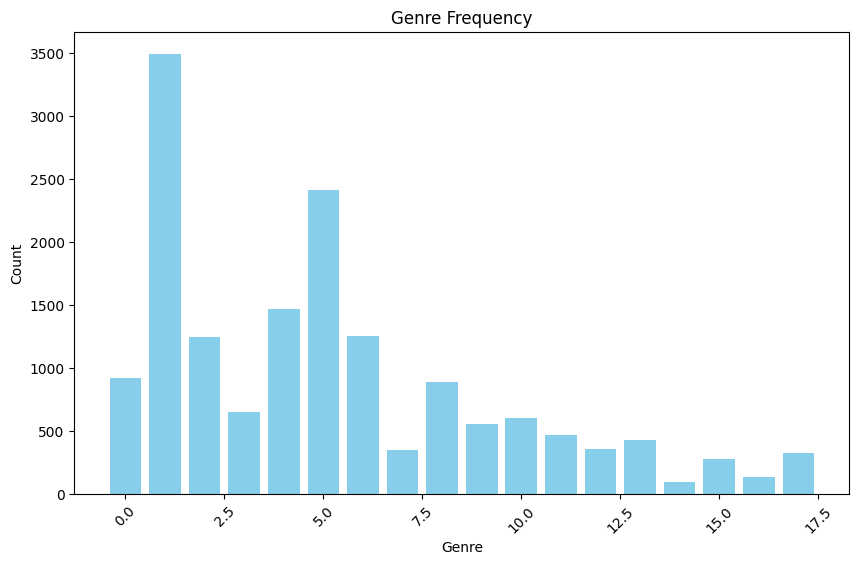

In [137]:
# 빈도 데이터프레임으로 변환
frequency_df = pd.DataFrame(frequency.items(), columns=['genre', 'count'])

# 빈도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(frequency_df['genre'], frequency_df['count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Frequency')
plt.xticks(rotation=45)
plt.show()

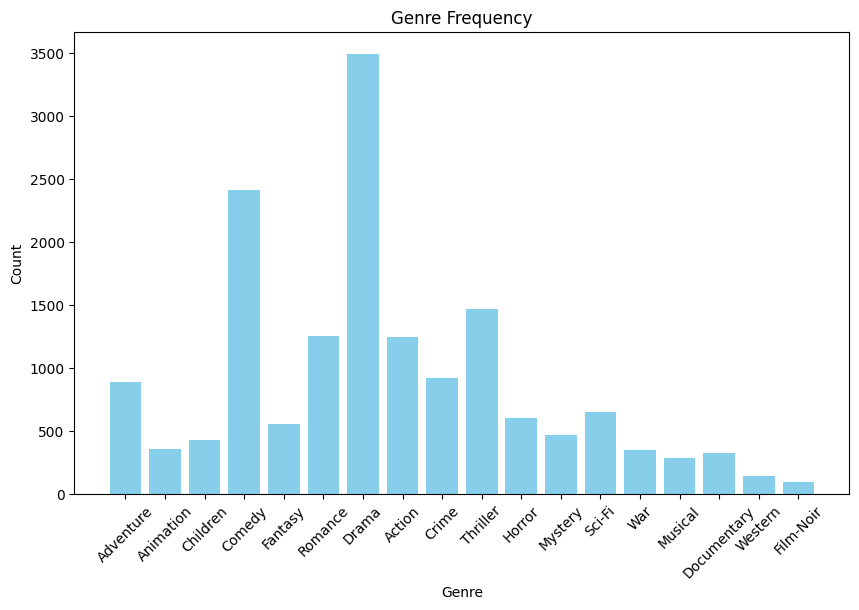

In [134]:
# 빈도 데이터프레임으로 변환
frequency_df = pd.DataFrame(frequency.items(), columns=['genre', 'count'])

# 빈도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(frequency_df['genre'], frequency_df['count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Frequency')
plt.xticks(rotation=45)
plt.show()

In [11]:
import pandas as pd
from collections import Counter

# 예시 데이터프레임 생성
data = {
    'user': ['A', 'B', 'C', 'D'],
    'genre': [['rock', 'pop'], ['rock',"a"], ['jazz', 'pop',"a"], ['rock', 'jazz']]
}

item_dup_genre_encod = pd.DataFrame(data)

# 빈도 계산
frequency = Counter(item_dup_genre_encod["genre"].sum())
# most_common_numbers = [num for num, count in frequency.most_common(3)]

# 우선순위 정의 (예시: rock > pop > jazz)
priority = {'rock': 2, 'pop': 1, 'jazz': 3, "a": 4}

# frequency를 우선순위에 따라 정렬
sorted_frequency = sorted(frequency.items(), key=lambda x: (-x[1], priority.get(x[0], float('inf'))))
# 빈도가 높은 순으로 3개까지 추출
most_common_numbers = [num for num, count in sorted_frequency[:3]]

# 결과 출력
print("빈도가 높은 장르 (우선순위 적용):", most_common_numbers)

빈도가 높은 장르 (우선순위 적용): ['rock', 'pop', 'jazz']


In [33]:
def fill_na(
        df: pd.DataFrame,
        col: str,
    ) -> pd.DataFrame:
    match col:
        case "year":
            df[col] = df[col].fillna(
                df["title"].str.extract(r"\((\d{4})\)", expand=False)  # 괄호 안 네 자리 숫자를 추출하는 정규표현식
            ).astype("int64")

        case _:
            df[col] = df[col].fillna(-1)
            df[col] = df[col].apply(lambda x: x if type(x) == list else [x])
    
    return df

In [ ]:
director_encod = label_encoding(directors, label_col="director", pivot_col="item")
item_dup_director_encod = director_encod.drop_duplicates(subset='item').reset_index(drop=True)
md = pd.merge(train_ratings, item_dup_director_encod, on="item", how="left")
fn_md = fill_na(df=md, col="director")
imsi = pd.DataFrame()
for u in fn_md["user"].unique():
    # 빈도 계산
    frequency = Counter(fn_md[fn_md["user"]==u]["director"].sum())

    # 빈도가 높은 순으로 3개까지 숫자 추출
    # count가 3 이상인 항목만 추출
    filtered_numbers = [(num, count) for num, count in frequency.items() if count >= 3]
    
    # count 기준으로 정렬 (내림차순)
    sorted_numbers = sorted(filtered_numbers, key=lambda x: x[1], reverse=True)

    # 최대 3개 항목만 선택
    # 빈도가 높은 순으로 3개까지 추출
    most_common_numbers = [num for num, count in sorted_numbers[:3]]
    # most_common_numbers가 비어있으면 [-1]대입
    # if len(most_common_numbers)==0:
    #     most_common_numbers=[-1]

    small_imsi = pd.DataFrame({"user": u, "gain_director": [most_common_numbers]})
    imsi = pd.concat([imsi, small_imsi],axis=0,sort=False)
mmd = pd.merge(md, imsi, on="user", how="left")
mmd

,user,item,time,director,gain_director
0,11,4643,1230782529,[47],"[-1, 35, 47]"
1,11,170,1230782534,[1111],"[-1, 35, 47]"
2,11,531,1230782539,[280],"[-1, 35, 47]"
3,11,616,1230782542,[1016],"[-1, 35, 47]"
4,11,2140,1230782563,"[84, 195]","[-1, 35, 47]"
...,...,...,...,...,...
5154466,138493,44022,1260209449,[1055],"[-1, 35, 47]"
5154467,138493,4958,1260209482,[911],"[-1, 35, 47]"
5154468,138493,68319,1260209720,[316],"[-1, 35, 47]"
5154469,138493,40819,1260209726,[307],"[-1, 35, 47]"


In [ ]:
mmd[mmd["user"]==11][]

In [88]:
frequency = Counter(mmd[mmd["user"]==11]["director"].sum())
frequency

Counter({-1: 43,
         35: 10,
         47: 6,
         58: 6,
         101: 6,
         16: 5,
         203: 5,
         248: 4,
         27: 4,
         129: 4,
         909: 4,
         30: 4,
         1092: 4,
         97: 4,
         159: 4,
         234: 3,
         672: 3,
         63: 3,
         94: 3,
         60: 3,
         1186: 3,
         1187: 3,
         313: 3,
         1017: 3,
         90: 3,
         231: 3,
         38: 3,
         221: 3,
         330: 3,
         1177: 3,
         516: 3,
         943: 3,
         53: 2,
         146: 2,
         1110: 2,
         387: 2,
         1206: 2,
         1207: 2,
         361: 2,
         1249: 2,
         617: 2,
         718: 2,
         764: 2,
         634: 2,
         25: 2,
         13: 2,
         1159: 2,
         1224: 2,
         34: 2,
         42: 2,
         379: 2,
         396: 2,
         1029: 2,
         213: 2,
         73: 2,
         1163: 2,
         88: 2,
         964: 2,
         1154: 2,
 

In [89]:
frequency = Counter(mmd[mmd["user"]==138493]["director"].sum())
frequency

Counter({-1: 17,
         35: 12,
         47: 9,
         170: 6,
         1016: 6,
         38: 5,
         617: 5,
         718: 5,
         834: 5,
         180: 4,
         12: 4,
         909: 4,
         63: 4,
         204: 4,
         764: 4,
         1086: 4,
         494: 3,
         926: 3,
         234: 3,
         321: 3,
         60: 3,
         1177: 3,
         42: 3,
         34: 3,
         307: 3,
         101: 3,
         330: 3,
         1167: 3,
         248: 3,
         1017: 3,
         313: 3,
         661: 3,
         1029: 3,
         203: 3,
         30: 3,
         943: 2,
         76: 2,
         523: 2,
         211: 2,
         31: 2,
         261: 2,
         231: 2,
         928: 2,
         73: 2,
         335: 2,
         334: 2,
         324: 2,
         327: 2,
         633: 2,
         37: 2,
         139: 2,
         94: 2,
         16: 2,
         974: 2,
         254: 2,
         243: 2,
         27: 2,
         239: 2,
         277: 2,
      

In [87]:
# 'genres' 열의 각 리스트의 길이를 계산
mmd['gain_genre_length'] = mmd['gain_director'].apply(len)
mmd["gain_genre_length"].unique()

array([3, 2, 1])

In [ ]:
mmd[mmd['user']==0]

In [83]:
mmd[mmd['gain_genre_length']==0]

,user,item,time,director,director_genre,gain_genre_length
22492,617,2076,1222534311,[31],[],0
22493,617,1962,1222534318,[136],[],0
22494,617,1479,1222534326,[946],[],0
22495,617,1947,1222534334,[1225],[],0
22496,617,2717,1222534351,[1017],[],0
...,...,...,...,...,...,...
5120354,137648,4161,1202309184,[1177],[],0
5120355,137648,7445,1248625110,[242],[],0
5120356,137648,665,1248625208,[211],[],0
5120357,137648,33679,1248625222,[816],[],0


In [81]:
frequency = Counter(mmd[mmd['gain_genre_length']==1]["director"].sum())
frequency

In [82]:
frequency

Counter({-1: 6311,
         35: 2503,
         943: 1602,
         38: 1515,
         101: 1347,
         60: 1261,
         203: 1145,
         16: 1037,
         94: 1029,
         27: 1006,
         34: 1005,
         164: 950,
         232: 862,
         50: 857,
         158: 826,
         157: 816,
         47: 804,
         244: 804,
         1167: 797,
         63: 779,
         5: 748,
         1186: 725,
         1187: 725,
         334: 705,
         374: 695,
         30: 660,
         167: 634,
         146: 627,
         23: 622,
         313: 610,
         73: 605,
         246: 594,
         1177: 560,
         159: 555,
         1092: 550,
         330: 549,
         428: 548,
         221: 542,
         2: 542,
         76: 513,
         633: 497,
         90: 494,
         71: 489,
         215: 482,
         254: 481,
         180: 481,
         550: 478,
         816: 475,
         1018: 468,
         25: 459,
         645: 458,
         253: 454,
         242: 439

In [67]:
mmd[mmd["user"]==11]

,user,item,time,director,director_genre
0,11,4643,1230782529,[47],"[47, 234, -1]"
1,11,170,1230782534,[1111],"[47, 234, -1]"
2,11,531,1230782539,[280],"[47, 234, -1]"
3,11,616,1230782542,[1016],"[47, 234, -1]"
4,11,2140,1230782563,"[84, 195]","[47, 234, -1]"
...,...,...,...,...,...
371,11,48738,1294796106,[838],"[47, 234, -1]"
372,11,6291,1294796113,[910],"[47, 234, -1]"
373,11,46578,1294796119,"[535, 579]","[47, 234, -1]"
374,11,7153,1294796132,[203],"[47, 234, -1]"


In [75]:
frequency = Counter(mmd[mmd["user"]==11]["director"].sum())
filtered_numbers = [(num, count) for num, count in frequency.items() if count >= 3]
# count 기준으로 정렬 (내림차순)
sorted_numbers = sorted(filtered_numbers, key=lambda x: x[1], reverse=True)
most_common_numbers = [num for num, count in sorted_numbers[:3]]
most_common_numbers
#most_common_numbers = [num for num, count in filtered_numbers.most_common(3)]
#most_common_numbers

[-1, 35, 47]

In [35]:
fn_md = fill_na(df=md, col="director")
fn_md.isna().sum()

user        0
item        0
time        0
director    0
dtype: int64

In [ ]:
genre_encod = label_encoding(genres, label_col="genre", pivot_col="item")
item_dup_genre_encod = genre_encod.drop_duplicates(subset='item').reset_index(drop=True)
md = pd.merge(train_ratings, item_dup_genre_encod, on="item", how="left")
imsi = pd.DataFrame()
for u in md["user"].unique():
    # 빈도 계산
    frequency = Counter(md[md["user"]==u]["genre"].sum())

    # 빈도가 높은 순으로 3개까지 숫자 추출
    most_common_numbers = [num for num, count in frequency.most_common(3)]

    # 우선순위 정의 

    # genre_character_priority = {"Drama": 1,
    #                             "Comedy": 2,
    #                             "Thriller": 3,
    #                             "Romance": 4,
    #                             "Action": 5,
    #                             "Crime": 6,
    #                             "Adventure": 7,
    #                             "Sci-Fi": 8,
    #                             "Horror": 9,
    #                             "Fantasy": 10,
    #                             "Mystery": 11,
    #                             "Children": 12,
    #                             "Animation": 13,
    #                             "War": 14,
    #                             "Documentary": 15,
    #                             "Musical": 16,
    #                             "Western": 17,
    #                             "Film-Noir": 18}

    genre_encoding_priority = {"1": 1,
                               "5": 2,
                               "4": 3,
                               "6": 4,
                               "2": 5,
                               "0": 6,
                               "8": 7,
                               "3": 8,
                               "10": 9,
                               "9": 10,
                               "11": 11,
                               "13": 12,
                               "12": 13,
                               "7": 14,
                               "17": 15,
                               "15": 16,
                               "16": 17,
                               "14": 18}

    # frequency를 우선순위에 따라 정렬
    sorted_frequency = sorted(frequency.items(), key=lambda x: (-x[1], genre_encoding_priority.get(x[0], float('inf'))))
    # 빈도가 높은 순으로 3개까지 추출
    most_common_numbers = [num for num, count in sorted_frequency[:3]]

    small_imsi = pd.DataFrame({"user": u, "gain_genre": [most_common_numbers]})
    imsi = pd.concat([imsi, small_imsi],axis=0,sort=False)
mmd = pd.merge(md, imsi, on="user", how="left")
mmd

In [41]:
item_dup_director_encod = fn_md.drop_duplicates(subset='item').reset_index(drop=True)
frequency = Counter(item_dup_director_encod["director"].sum())
frequency

Counter({-1: 1304,
         12: 44,
         2: 33,
         23: 31,
         35: 29,
         34: 26,
         246: 23,
         27: 20,
         1232: 20,
         94: 19,
         201: 19,
         100: 19,
         6: 19,
         0: 19,
         215: 18,
         196: 18,
         47: 17,
         158: 17,
         192: 17,
         109: 17,
         170: 17,
         89: 17,
         17: 17,
         37: 16,
         55: 16,
         239: 16,
         157: 16,
         224: 16,
         61: 16,
         53: 15,
         101: 15,
         42: 15,
         242: 15,
         78: 15,
         268: 15,
         728: 15,
         234: 14,
         203: 14,
         50: 14,
         232: 14,
         277: 14,
         261: 14,
         216: 14,
         21: 14,
         190: 13,
         74: 13,
         90: 13,
         40: 13,
         172: 13,
         77: 13,
         43: 13,
         1016: 12,
         84: 12,
         63: 12,
         1017: 12,
         163: 12,
         332: 12,


In [60]:
len(directors["director"].unique())

1340

In [47]:
item_dup_director_encod

,user,item,time,director
0,11,4643,1230782529,[47]
1,11,170,1230782534,[1111]
2,11,531,1230782539,[280]
3,11,616,1230782542,[1016]
4,11,2140,1230782563,"[84, 195]"
...,...,...,...,...
6802,13666,7753,1147095751,[717]
6803,15701,93422,1366695863,[-1]
6804,15839,6519,1272797536,[779]
6805,16533,8830,1302660954,[818]


In [59]:
item_dup_director_encod[item_dup_director_encod["director"].apply(lambda x: 12 in x)]

,user,item,time,director
566,18,1230,1236293194,[12]
567,18,3812,1236293215,[12]
910,58,348,1144059684,[12]
937,58,1244,1144060108,[12]
1010,58,2065,1144061399,[12]
1633,132,6993,1114104484,[12]
1675,133,86882,1397241173,[12]
1763,154,46967,1158887074,[12]
1863,201,1078,1216030429,[12]
1905,205,2750,1201772648,[12]
